In [49]:
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A
import warnings
import glob
import random
import cv2
import os
import math
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

1. Load and normalize the training and test datasets
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### Initialize dataset loader

In [26]:
class FruitDatasetFolder(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.img_paths = glob.glob(f"{path}/**/**.jpg") + glob.glob(f"{path}/**/**.png")
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = img_path.split("/")[-2]
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img, label

In [ ]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [59]:
total_classes = os.listdir("datasets/fruits-360/Training")
n_classes = len(total_classes)

training_folder = FruitDatasetFolder("datasets/fruits-360/Training", augmentation)
training_set = DataLoader(training_folder, batch_size=64, shuffle=True)

val_folder = FruitDatasetFolder("datasets/fruits-360/Test")
val_set = DataLoader(val_folder, batch_size=64, shuffle=True)

In [46]:
unique_img_classes = {}

for batch in training_set:
    for index, label in enumerate(batch[1]):
        if label not in unique_img_classes:
            unique_img_classes[label] = batch[0][index]
            
    if len(total_classes) == len(unique_img_classes):
         break

### Visualize dataset

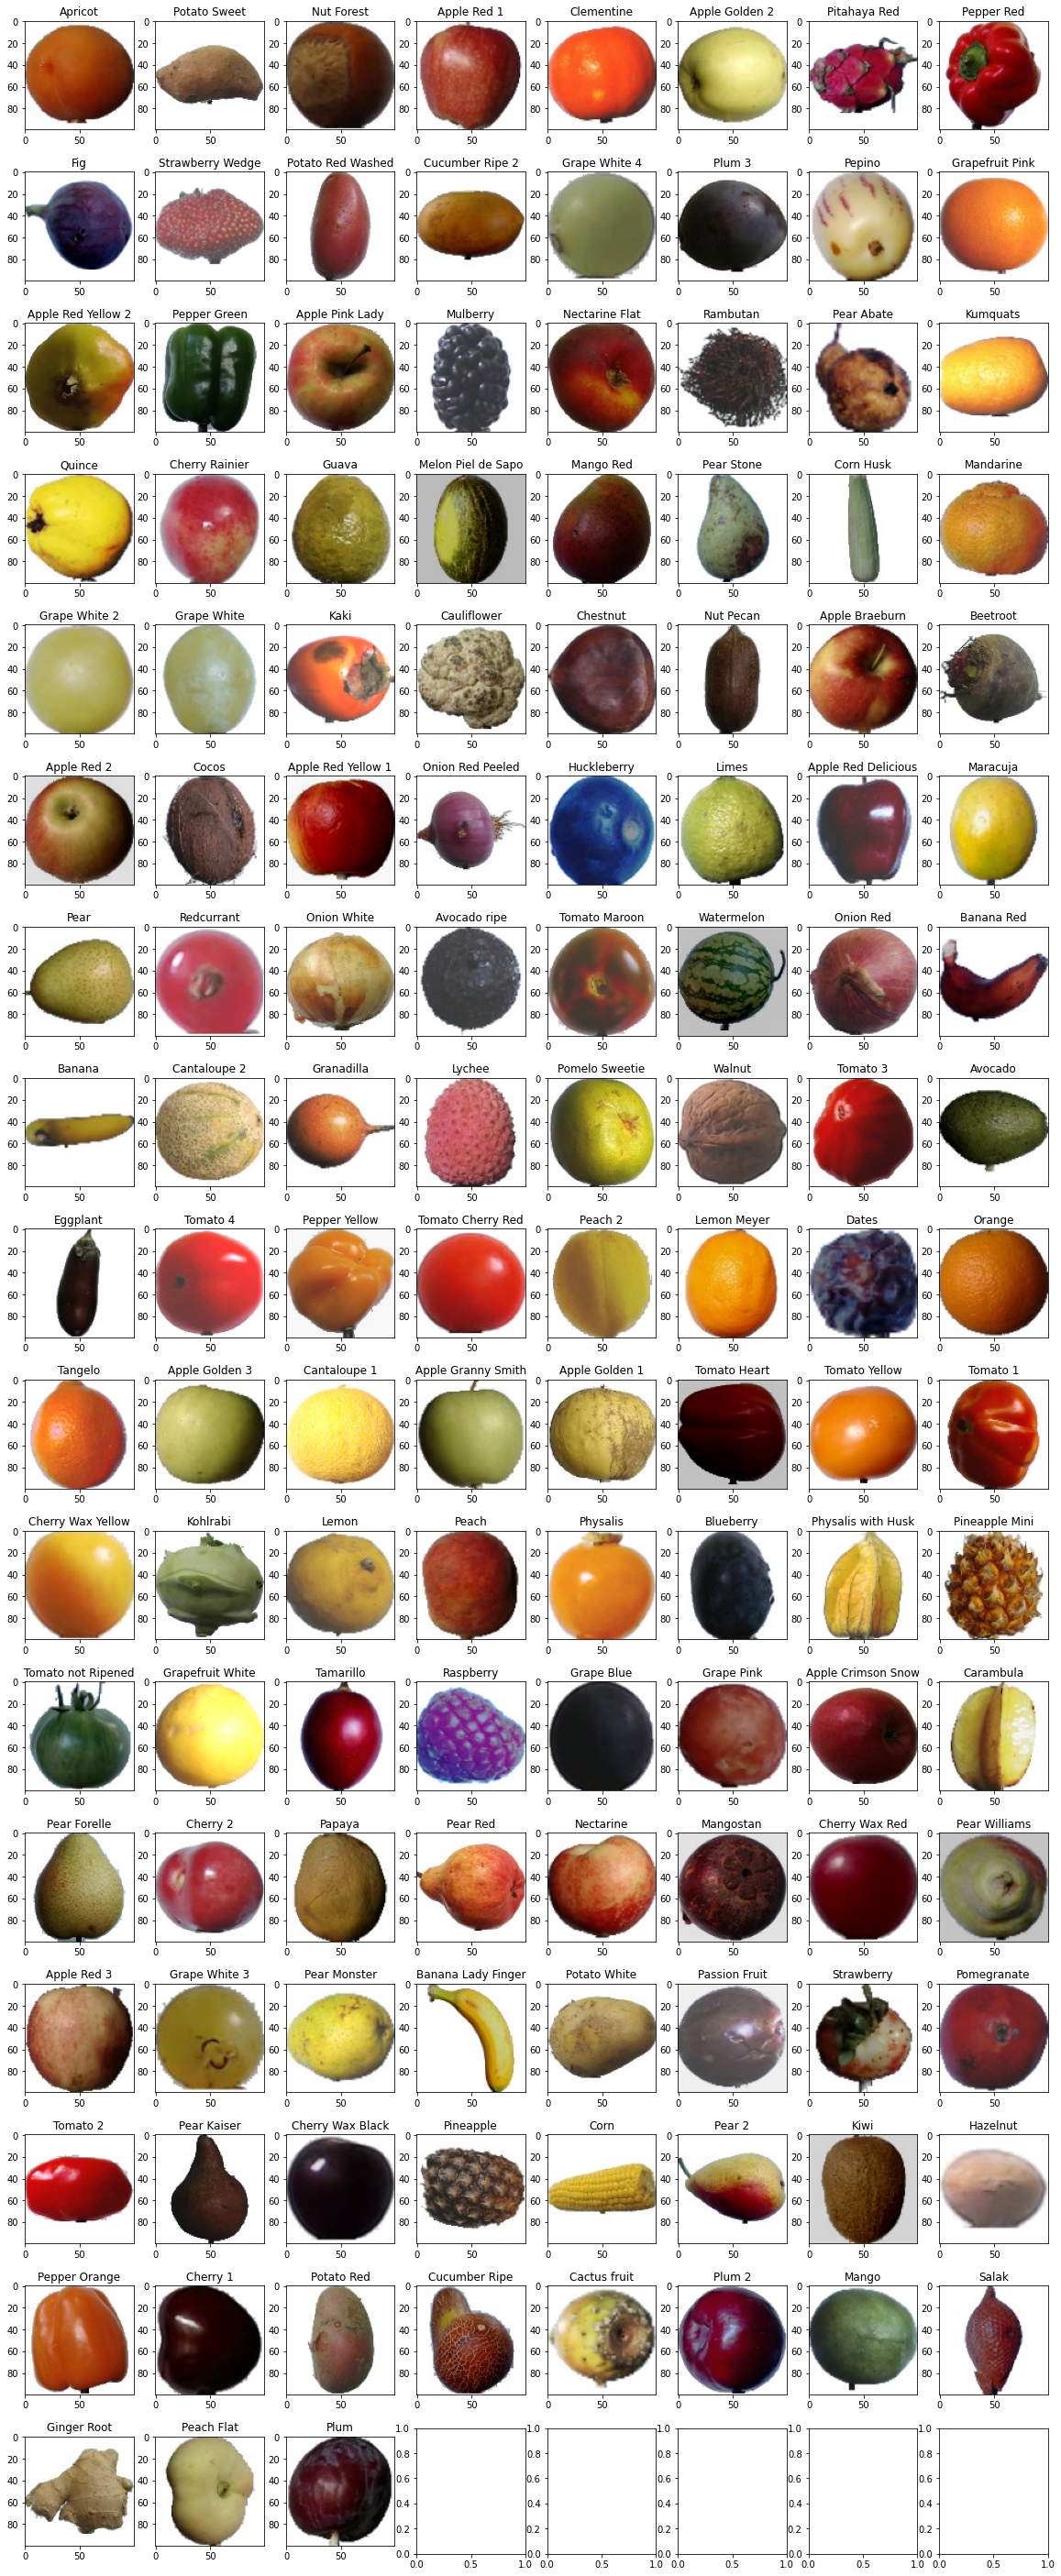

In [56]:
imgs_per_row = 8
total_rows = math.ceil(len(unique_img_classes) / imgs_per_row)
visualize_labels = list(unique_img_classes.keys())
visualize_imgs = list(unique_img_classes.values())
index = 0

fig, ax = plt.subplots(total_rows, imgs_per_row, figsize=(20, total_rows * 3))

for row in range(total_rows):
    for col in range(imgs_per_row):
        if index >= len(unique_img_classes):
            break
            
        ax[row][col].imshow(visualize_imgs[index])
        ax[row][col].set_title(visualize_labels[index])
        
        index += 1
        
plt.show()

### Define model

For demonstration, I implement VGG-11 for re-ultilizing the VGG layer

![VGG-11](https://imgur.com/uLXrKxe.jpg)

In [73]:
def vgg_layer(num_conv, channel, prev_channel):
    layers = []
    
    for i in range(num_conv):
        layers.append(nn.Conv2d(prev_channel, channel, kernel_size=3, padding=1))  # should we use bias in Convolutional Layer
        layers.append(nn.ReLU())
        prev_channel = channel
        
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
    return nn.Sequential(*layers)

In [74]:
class FruitClassification(nn.Module):
    def __init__(self, n_classes: int):
        super(FruitClassification, self).__init__()
        
        self.layers = nn.Sequential(
            vgg_layer(1, 64, 3),
            vgg_layer(1, 128, 64),
            vgg_layer(2, 256, 128),
            vgg_layer(2, 512, 256),
            vgg_layer(2, 512, 512),
            nn.Flatten(),
            nn.Linear(4096, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, n_classes)
        )
        
    def forward(self, img):
        return self.layers(img)

In [75]:
model = FruitClassification(n_classes)
model

FruitClassification(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPoo

In [78]:
!pip install torchinfo

In [79]:
from torchinfo import summary

In [80]:
summary(model)
# model(visualize_imgs[0].reshape(1, 100, 100, 3).permute(0, 3, 1, 2))

Layer (type:depth-idx)                   Param #
FruitClassification                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-4                  73,856
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-7                  295,168
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  590,080
│    │    └─ReLU: 3-10                   --
│    │    └─MaxPool2d: 3-11              --
│    └─Sequential: 2-4                   --
│    │    └─Conv2d: 3-12                 1,180,160
│    │    └─ReLU: 3-13                   --
│    │    └─Conv2d: 3-14                 2,359,808
│    │    └─ReLU: 3-15                  